<a href="https://colab.research.google.com/github/Walbyq/data-science/blob/main/credit-card-fraud/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [2]:
# Библиотеки для чтения и анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Бибилиотеки для обучения
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

from imblearn.over_sampling import SMOTE # Библиотека для балансировки данных
from imblearn.pipeline import Pipeline # Библиотека для создания пайплайнов

# Подготовка данных

In [3]:
# Подключаемся к Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Получаем датафрейм
csv_file_path = '/content/drive/MyDrive/ML/datasets/creditcard.csv'
df = pd.read_csv(csv_file_path)

Ссылка на набор данных: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Столбцы датафрейма:

*   **Time** - количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных;
*   **V1-V28** - главные компоненты, полученные с помощью метода главных компонент;
*   **Amount** - сумма транзакции;
*   **Class** - переменная ответа (в случае мошенничества 1, в противном случае 0).

# Настройка стилей

In [5]:
# Установка стиля
sns.set_style('darkgrid')

# Настройка палитры
color_mod = 'coolwarm'
full_palette = sns.color_palette(color_mod, 6)
palette = [full_palette[0], full_palette[-1]]
sns.set_palette(palette)

In [6]:
# Палитра для тепловой карты
sns.color_palette(color_mod)

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

In [7]:
# Палитра для графиков
sns.color_palette(palette)

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

# Анализ данных

In [8]:
# Выводим размерность
df.shape

(284807, 31)

In [22]:
# Выводим первые 5 значений
df.head().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.0,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.0,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.0,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.0,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [10]:
# Выводим основные статистические характеристики данных по каждому числовому признаку
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [11]:
# Выводим основную информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
# Выводим количество пустых значений
df.isnull().sum().max()

0

In [13]:
# Распределение классов
df['Class'].value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


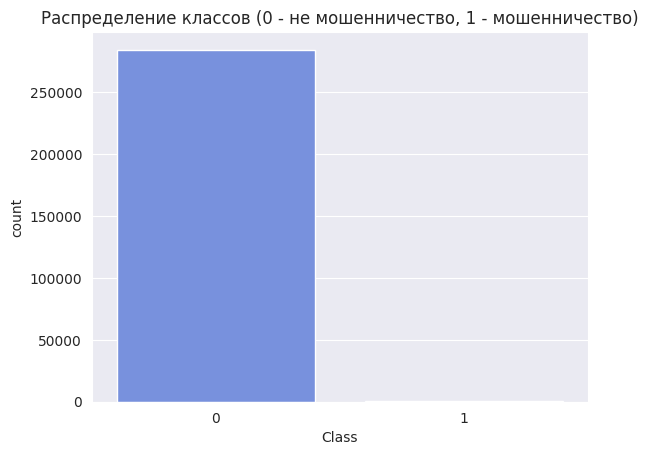

In [14]:
# Визуализация распределения классов
sns.countplot(df, x='Class')
plt.title('Распределение классов (0 - не мошенничество, 1 - мошенничество)')
plt.show()

Данные сильно несбалансированы: мошеннические транзакции составляют очень малую часть от общего числа.

# Предобработка данных

Выполним скалярную стандартизацию и разделение данных:

In [15]:
# Отделяем признаки от целевой переменной
X = df.drop('Class', axis=1)
y = df['Class']

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание и обучение модели

In [27]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

# Оценка модели

Оценим точность модели на обучающей и тестовой выборках:

In [29]:
# Оценка модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Расчет метрик
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='binary')
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

print("Точность обучения:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")

Точность обучения:
Precision: 0.8636
Recall: 0.5816
F1-score: 0.6951


## Построение ROC-кривой

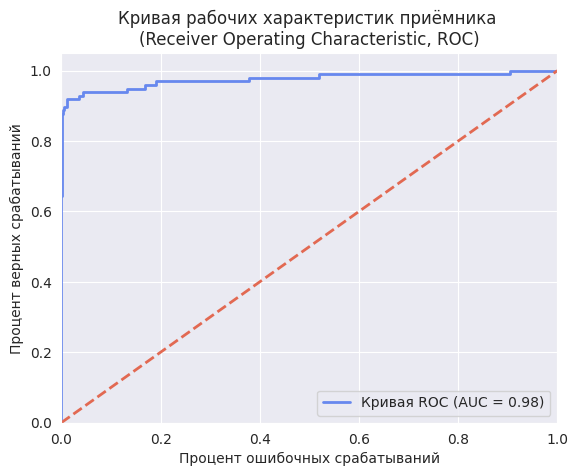

In [30]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'Кривая ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Процент ошибочных срабатываний')
plt.ylabel('Процент верных срабатываний')
plt.title('Кривая рабочих характеристик приёмника \n(Receiver Operating Characteristic, ROC)')
plt.legend(loc="lower right")
plt.show()

## Кросс-валидация

Проведем кросс-валидацию и отобразим метрики:

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='f1')

print("Результаты кросс-валидации (F1-score):")
print(f"Средний F1-score: {cv_scores.mean():.4f}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")

Результаты кросс-валидации (F1-score):
Средний F1-score: 0.7222
Стандартное отклонение: 0.0325
